# Dataset Analysis and Clustering

## Basic Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Import dataset

### Load `csv`

In [2]:
dataset = pd.read_csv("data/mallCustomers.csv")

# Set the display format to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dataset

,CustomerID,Genre,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## Dataset Analysis

Here we will analyze the dataset to understand the data and its structure.


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Genre           200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual Income   200 non-null    int64 
 4   Spending Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In this case the dataset does not contain any missing values, and has a non-numeric type column `Genre`

Next, we see the descriptive statistics of the dataset.

In [4]:
dataset.describe()

,CustomerID,Age,Annual Income,Spending Score
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


A clearer view of the null values in the dataset is shown below.
In this case as previously mentioned, there are no missing values in the dataset.

In [5]:
dataset.isnull().sum()

CustomerID        0
Genre             0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

Find the amount of unique values in the dataset

In [6]:
dataset.nunique()

CustomerID        200
Genre               2
Age                51
Annual Income      64
Spending Score     84
dtype: int64

Study the correlation between the numeric variables for later use in the classification model.

In [7]:
sns.set_palette("tab10")

In [8]:
dataset.groupby("Genre").count()

,CustomerID,Age,Annual Income,Spending Score
Genre,,,,
Female,112,112,112,112
Male,88,88,88,88


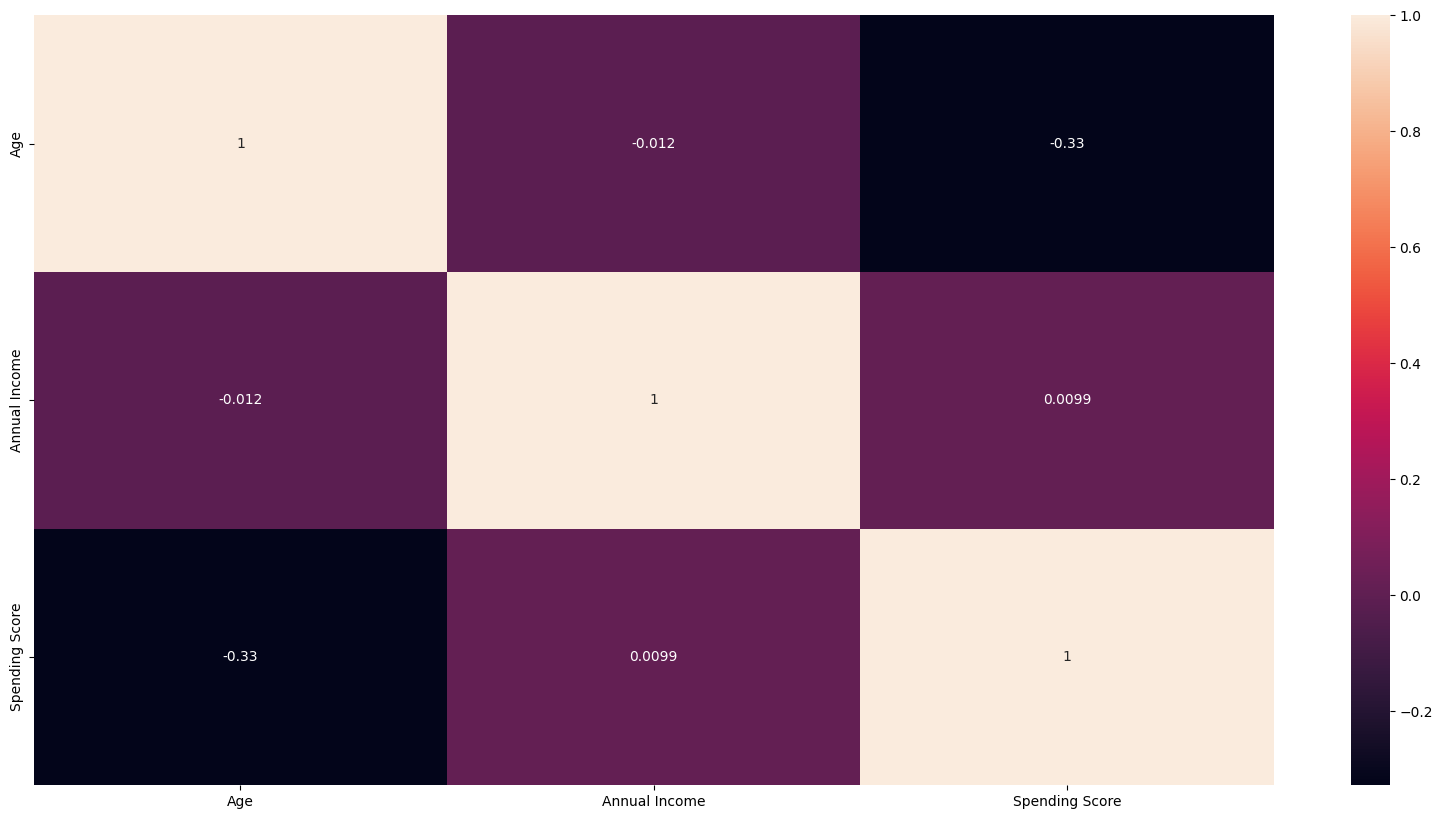

In [9]:
plt.rcParams['figure.figsize'] = (20, 10)

sns.heatmap(dataset.drop('CustomerID', axis=1).dropna().corr(numeric_only=True), annot=True)

plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

Visualize in pairplots the correlation between important metrics in the dataset,
divided by the `churn`, to see if there is a clear difference between the two classes.

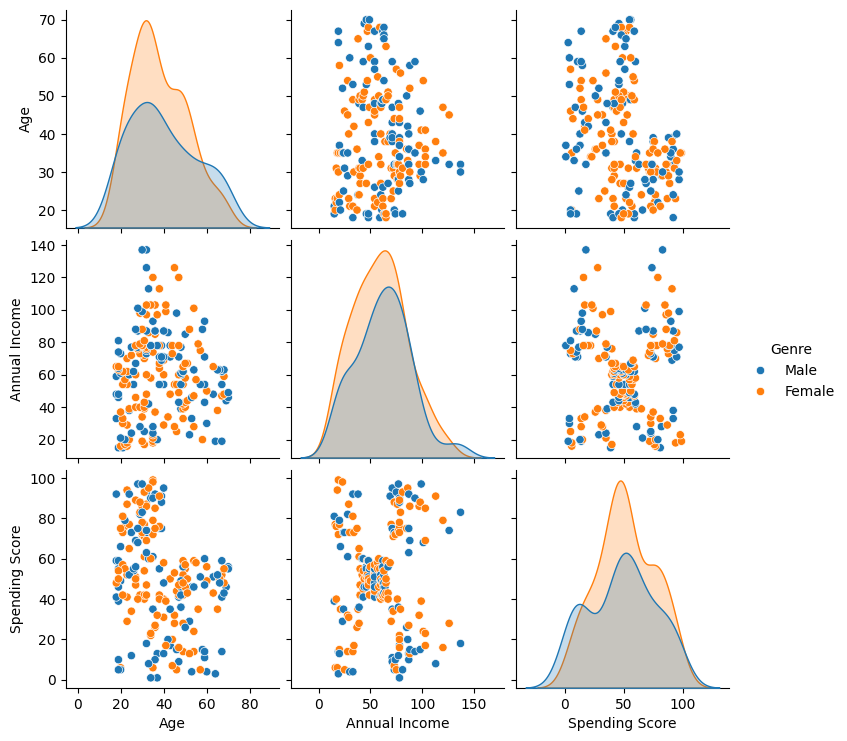

In [10]:
numeric_columns = ['Age', 'Annual Income', 'Spending Score']

sns.pairplot(dataset, vars=numeric_columns, hue='Genre')
plt.show()

## Preprocessing

### Outliers

In [11]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import HDBSCAN

mask = dataset['Genre'] == 'Male'
male_dataset = dataset[mask].reset_index()
female_dataset = dataset[~mask].reset_index()

columns = numeric_columns
datasets = [
  ("male", male_dataset, 0.02), 
  ("female", female_dataset, 0.05)
]

print("male: ", male_dataset.shape)
print("female: ", female_dataset.shape)

male:  (88, 6)
female:  (112, 6)


0.06818181818181818
0.16071428571428573


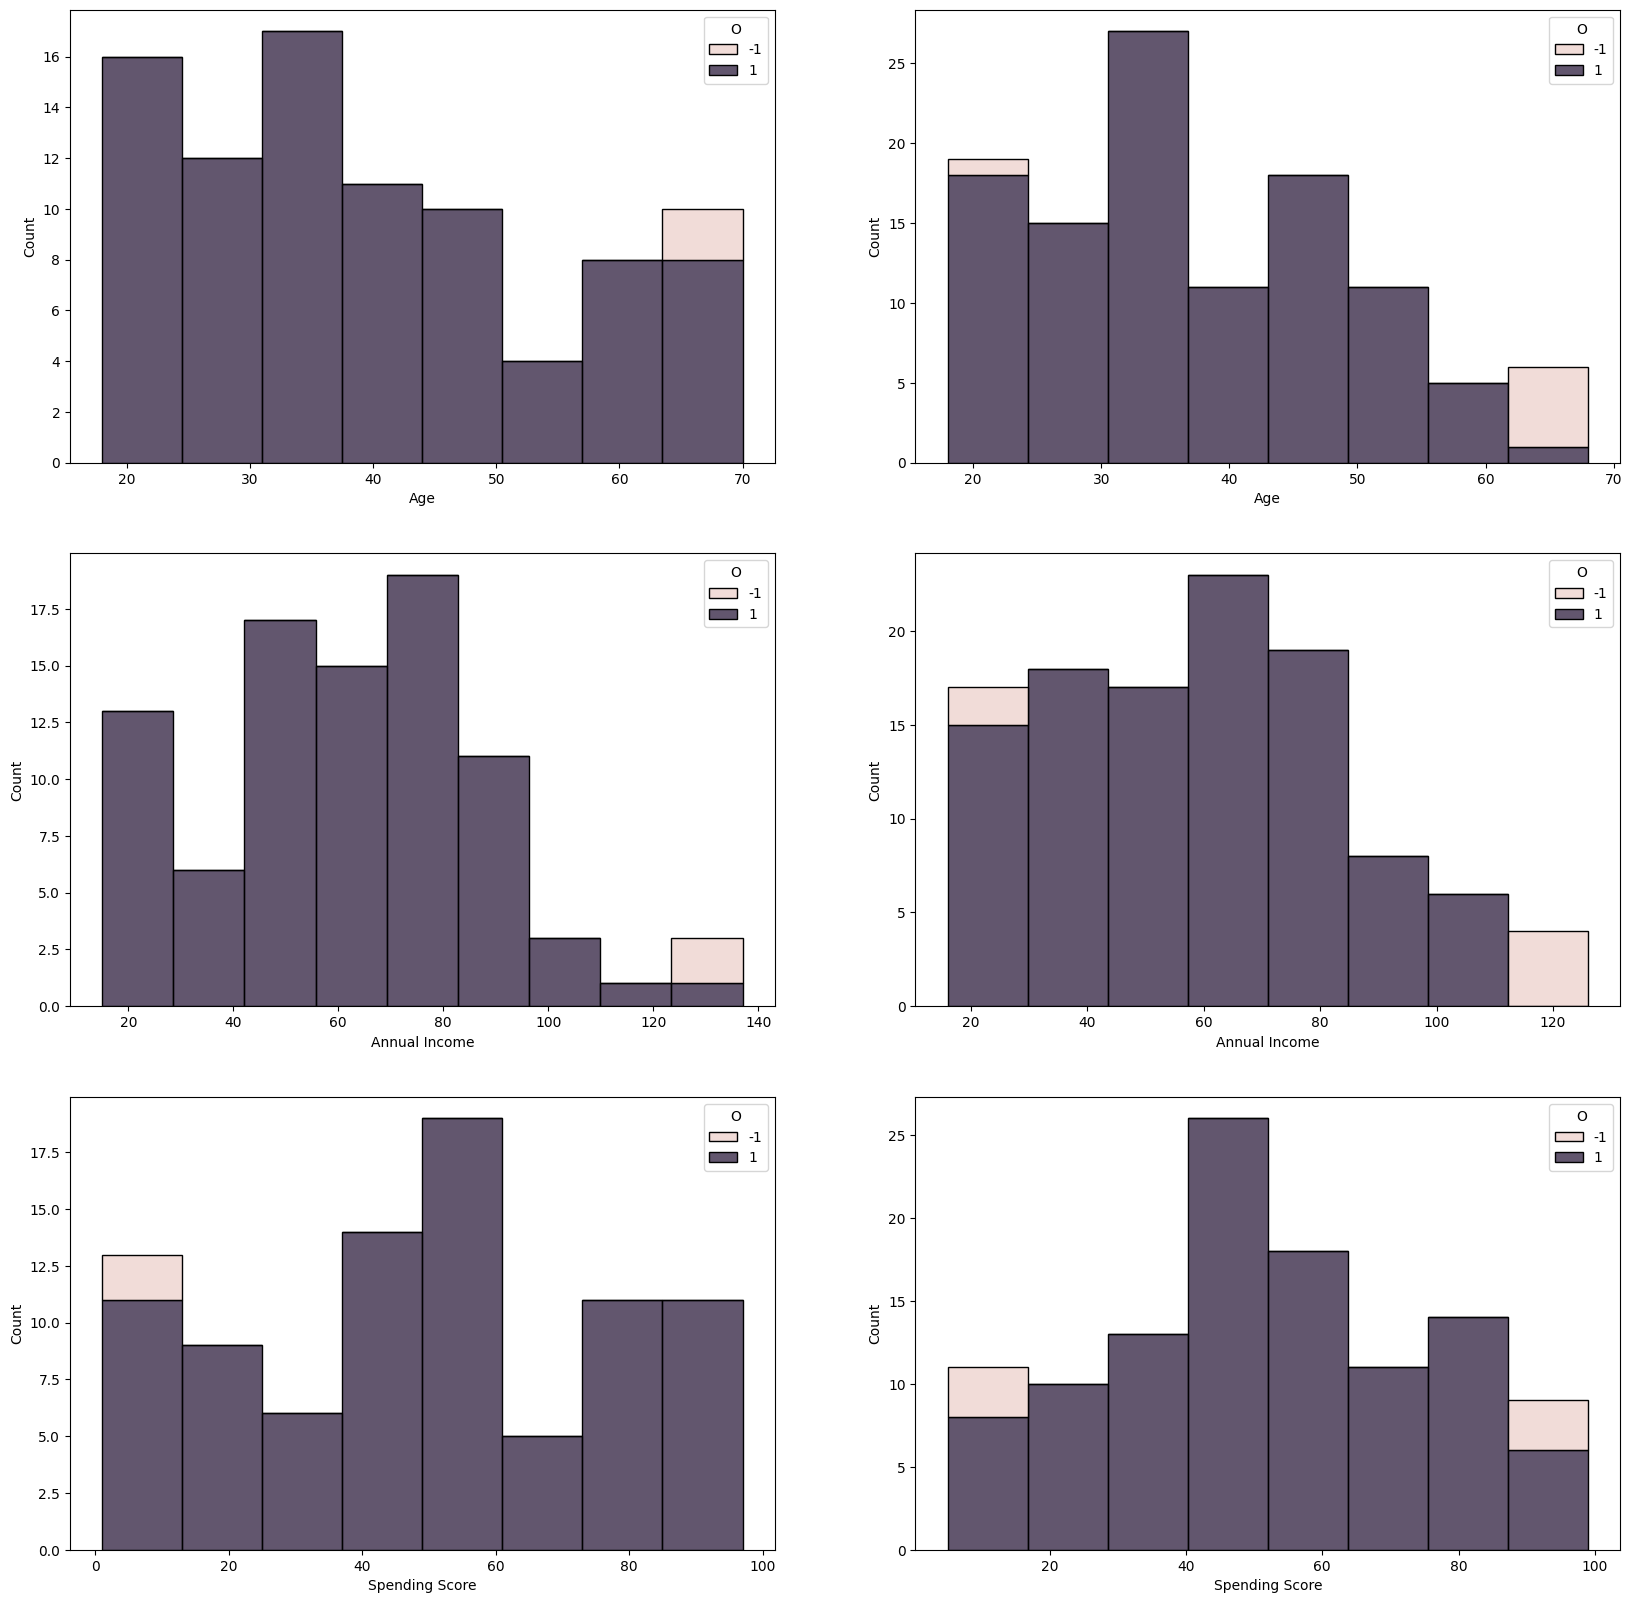

In [12]:
plt.rcParams['figure.figsize'] = (20, 20)

fig, axes = plt.subplots(nrows=len(columns), ncols=len(datasets))
outlier_count = {
  "male": 0,
  "female": 0
}

outliers_customers_ids = set()

for i, ax in enumerate(axes.flatten()):
  dataset_index = i % len(datasets)
  tag, split_dataset, contamination = datasets[dataset_index]
  dataset_pair = datasets[dataset_index]
  column = columns[int(i / len(datasets))]
  clf = IsolationForest(contamination=contamination, random_state=42)
  outliers = clf.fit_predict(split_dataset[[column]])
  outliers_df = pd.DataFrame(outliers, columns=list("O"))
  outliers_df = split_dataset.join(outliers_df)
  outlier_count[dataset_pair[0]] += outliers_df[outliers_df["O"] == -1].shape[0]
  outliers_customers_ids = outliers_customers_ids.union(outliers_df[outliers_df['O'] == -1]["CustomerID"])
  sns.histplot(outliers_df, x=column, hue="O", multiple="stack", ax = ax)
  # sns.boxplot(outliers_df, y=column, hue="O", ax=ax)

print(outlier_count["male"] / len(male_dataset))
print(outlier_count["female"] / len(female_dataset))

dataset = dataset[dataset["CustomerID"].isin(outliers_customers_ids) == False]

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [13]:
dataset.count()

CustomerID        176
Genre             176
Age               176
Annual Income     176
Spending Score    176
dtype: int64

### Drop ids

Firstly we remove the `customer_id` column, as it is not relevant for the classification model.

In [14]:
dataset = dataset.drop('CustomerID', axis=1)
dataset

,Genre,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
4,Female,31,17,40
5,Female,22,17,76
6,Female,35,18,6
...,...,...,...,...
189,Female,36,103,85
190,Female,34,103,23
191,Female,32,103,69
192,Male,33,113,8


### Transformation Pipeline

Next we create a pipeline to preprocess the data, which includes:
  - `OneHotEncoder` for the non-numeric columns, that make sense as numeric, in this case `Genre`.
  - `StandardScaler` for the numeric columns, to scale the data and make it easier for the model to classify.

After defining the pipeline, we `fit` it to the dataset and transform the data.

In [15]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import numpy as np
from sklearn import set_config

set_config(transform_output = "pandas")

pipeline = ColumnTransformer(
    [   
        ("text", OrdinalEncoder(), ["Genre"]),
        ("numeric", MinMaxScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

preprocessed_dataset = pipeline.fit_transform(dataset)
preprocessed_dataset

,Genre,Age,Annual Income,Spending Score
0,1.00,0.02,0.00,0.38
1,1.00,0.06,0.00,0.83
4,0.00,0.25,0.02,0.39
5,0.00,0.08,0.02,0.78
6,0.00,0.33,0.03,0.03
...,...,...,...,...
189,0.00,0.35,0.79,0.87
190,0.00,0.31,0.79,0.21
191,0.00,0.27,0.79,0.70
192,1.00,0.29,0.88,0.05


As previously seen in the dataset analysis, the dataset is imbalanced, so we will use the `SMOTE` algorithm to balance the dataset.

### Export Preprocessed Dataset

In [16]:
pd.DataFrame(preprocessed_dataset).to_csv('data/preprocessed-mallCustomers.csv', index=False)

## Clustering

### Import Preprocessed Dataset

In [17]:
preprocessed_dataset = pd.read_csv("data/preprocessed-mallCustomers.csv")

### K-Means

#### Elbow Method

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

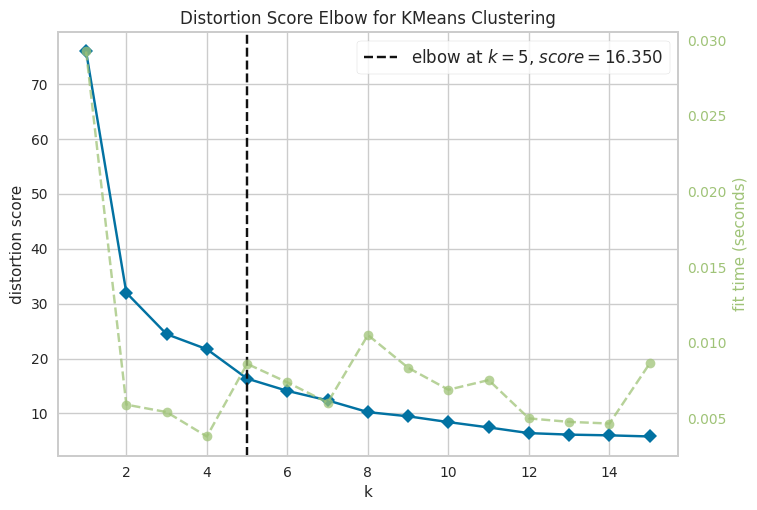

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Ignoramos el warning de pronto vencimiento de la librería

import setuptools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

test_range = (1, 16)
inertia = [] # Lista para almacenar los valores de la inercia (within-cluster sum of squares)

kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=test_range)
visualizer.fit(preprocessed_dataset)
visualizer.show()

Optimal value for k is `k=5`

#### Silhouette Method

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

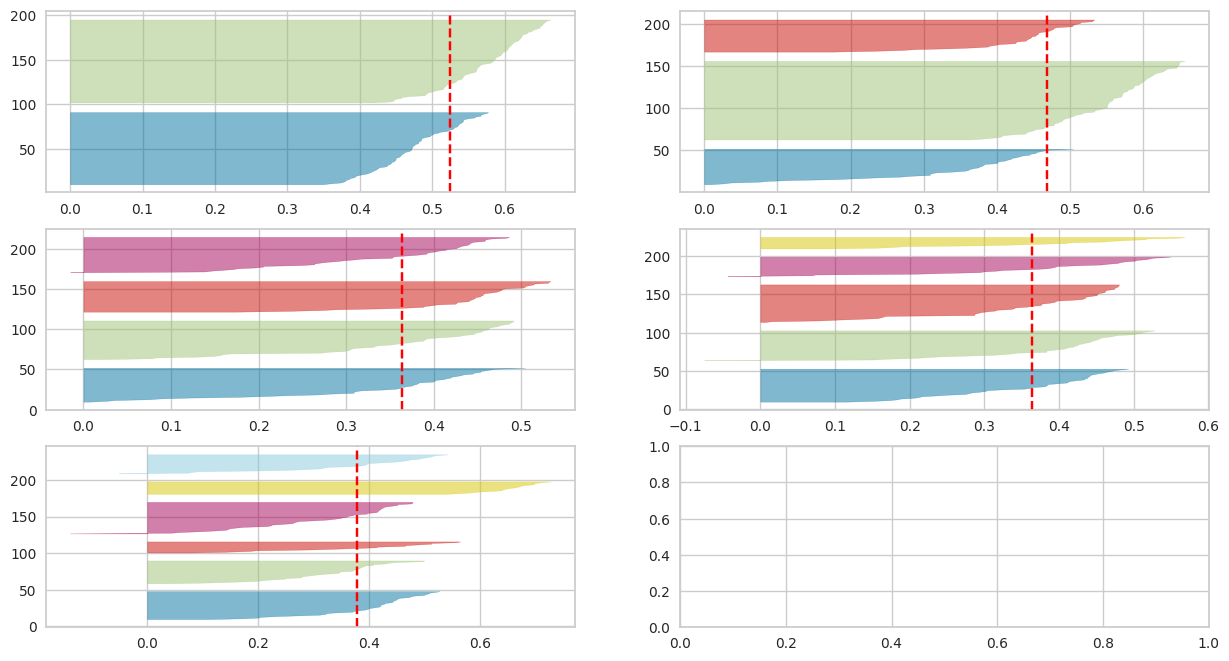

In [19]:
import setuptools
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(preprocessed_dataset) 

Optimal value for k is `k=5`

#### Results

In [20]:
kmeans = KMeans(n_clusters=5, random_state=42) # Aplicar K-Means con K=8
kmeans.fit(preprocessed_dataset)

cluster_labels = kmeans.labels_ # Asis etiquetas de cluster a los datos

preprocessed_dataset['Cluster'] = cluster_labels # Agregar las etiquetas de cluster al conjunto de datos original

# Calcula la media de las variables numéricas y la moda de las variables categóricas
cluster_aggregated = preprocessed_dataset.groupby('Cluster').agg(lambda x: x.mode().iloc[0] if x.dtype == 'object' else x.mean())

print(cluster_aggregated)

         Genre  Age  Annual Income  Spending Score
Cluster                                           
0         1.00 0.73           0.34            0.35
1         0.00 0.54           0.37            0.36
2         1.00 0.20           0.41            0.73
3         1.00 0.31           0.62            0.09
4         0.00 0.19           0.41            0.68


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

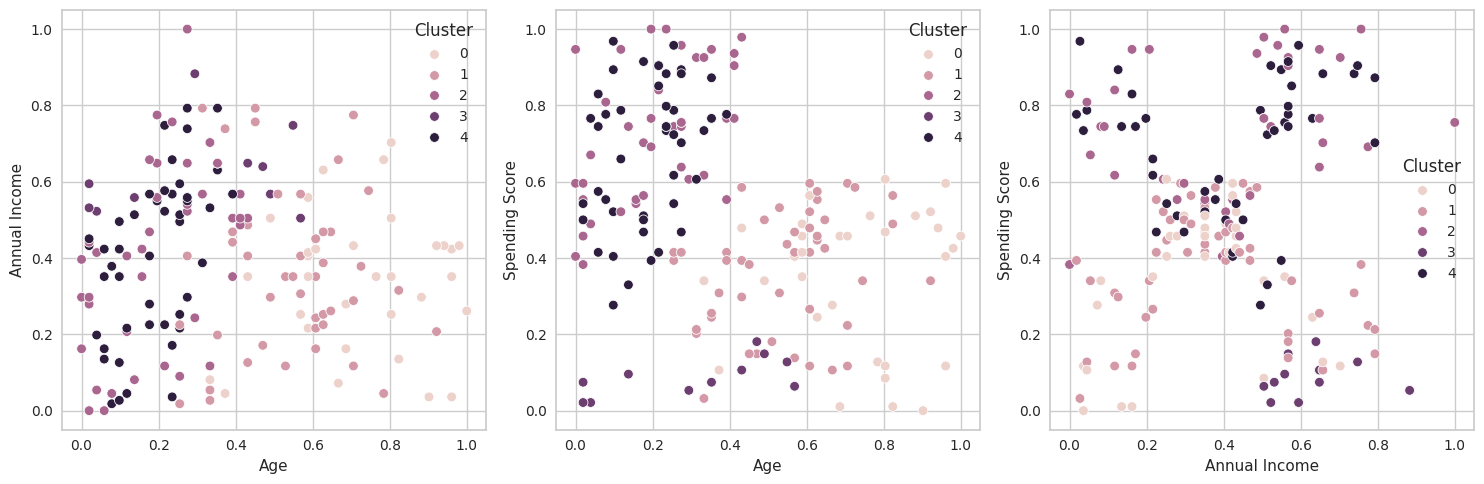

In [69]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(preprocessed_dataset, x='Age', y='Annual Income', hue='Cluster', ax=axs[0])
sns.scatterplot(preprocessed_dataset, x='Age', y='Spending Score', hue='Cluster', ax=axs[1])
sns.scatterplot(preprocessed_dataset, x='Annual Income', y='Spending Score', hue='Cluster', ax=axs[2])


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

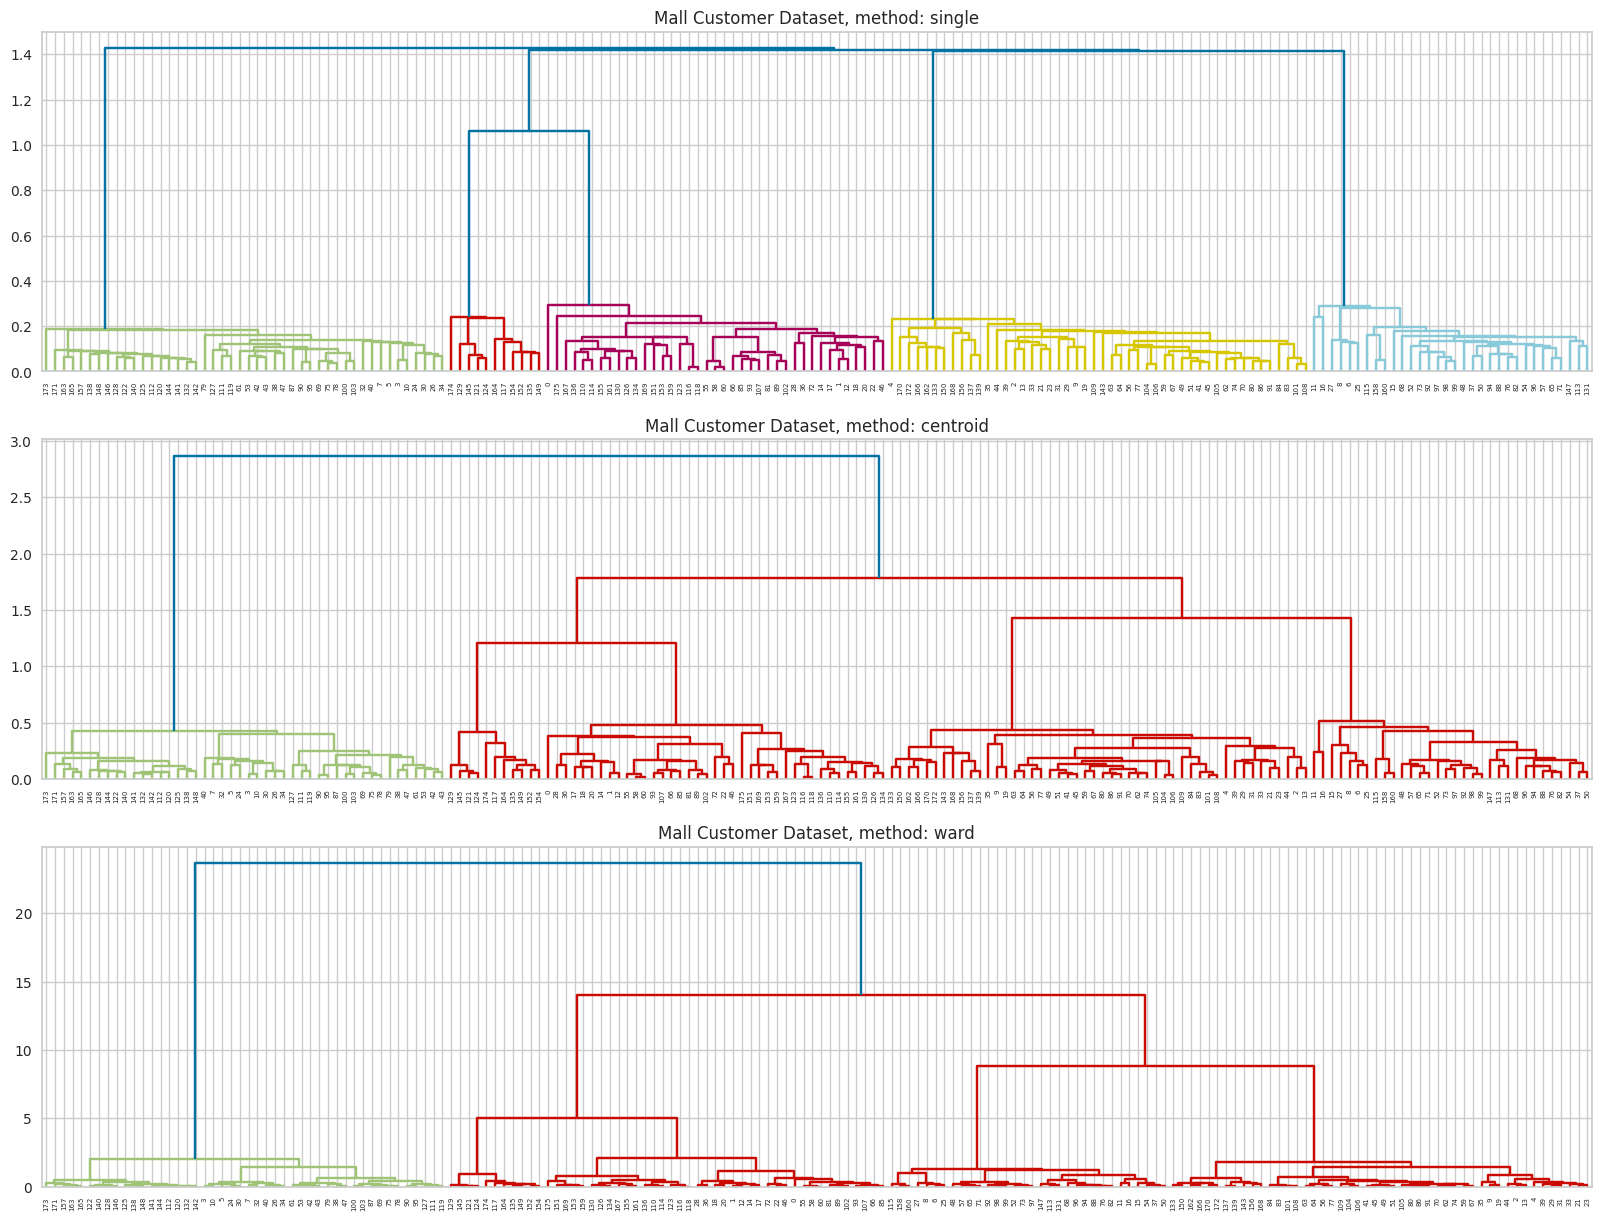

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram

methods = ['single', 'centroid', 'ward']

fig, axs = plt.subplots(len(methods), 1, figsize=(20,15))

for i, ax in enumerate(axs):
  ax.set_title('Mall Customer Dataset, method: {}'.format(methods[i]))
  mergings = linkage(preprocessed_dataset, method = methods[i])
  dendrogram(mergings, ax = ax)

### KMeans (Male, Female)

#### Split dataset

In [22]:
male_dataset = preprocessed_dataset[preprocessed_dataset['Genre'] == 1]
female_dataset = preprocessed_dataset[preprocessed_dataset['Genre'] == 0]

print(male_dataset)
print(female_dataset)

     Genre  Age  Annual Income  Spending Score  Cluster
0     1.00 0.02           0.00            0.38        2
1     1.00 0.06           0.00            0.83        2
6     1.00 0.90           0.04            0.00        0
8     1.00 0.96           0.04            0.12        0
11    1.00 0.37           0.05            0.11        0
..     ...  ...            ...             ...      ...
164   1.00 0.55           0.75            0.13        3
167   1.00 0.24           0.76            1.00        2
169   1.00 0.20           0.77            0.69        2
174   1.00 0.29           0.88            0.05        3
175   1.00 0.27           1.00            0.76        2

[82 rows x 5 columns]
     Genre  Age  Annual Income  Spending Score  Cluster
2     0.00 0.25           0.02            0.39        1
3     0.00 0.08           0.02            0.78        4
4     0.00 0.33           0.03            0.03        1
5     0.00 0.10           0.03            0.97        4
7     0.00 0.24          

#### Elbow Method

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

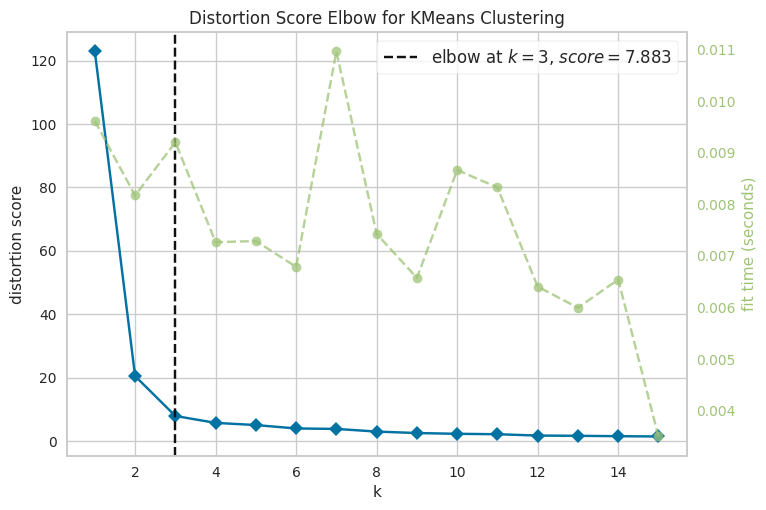

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

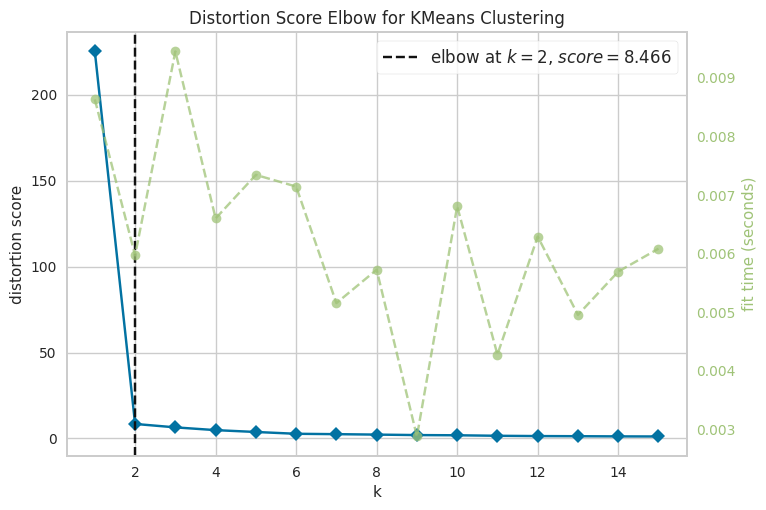

In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Ignoramos el warning de pronto vencimiento de la librería

import setuptools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

datasets = [male_dataset, female_dataset]
test_range = (1, 16)
inertia = [] # Lista para almacenar los valores de la inercia (within-cluster sum of squares)

for train_dataset in datasets:
  kmeans = KMeans(random_state=42)
  visualizer = KElbowVisualizer(kmeans, k=test_range)
  visualizer.fit(train_dataset)
  visualizer.show()

#### Results

##### Male Dataset

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42) # Aplicar K-Means con K=8
kmeans.fit(male_dataset)

cluster_labels = kmeans.labels_ # Asis etiquetas de cluster a los datos

male_dataset['Cluster'] = cluster_labels # Agregar las etiquetas de cluster al conjunto de datos original

# Calcula la media de las variables numéricas y la moda de las variables categóricas
cluster_aggregated = male_dataset.groupby('Cluster').agg(lambda x: x.mode().iloc[0] if x.dtype == 'object' else x.mean())

print(cluster_aggregated)

         Genre  Age  Annual Income  Spending Score
Cluster                                           
0         1.00 0.31           0.62            0.09
1         1.00 0.20           0.41            0.73
2         1.00 0.73           0.34            0.35


/tmp/ipykernel_6869/877340313.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_dataset['Cluster'] = cluster_labels # Agregar las etiquetas de cluster al conjunto de datos original


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

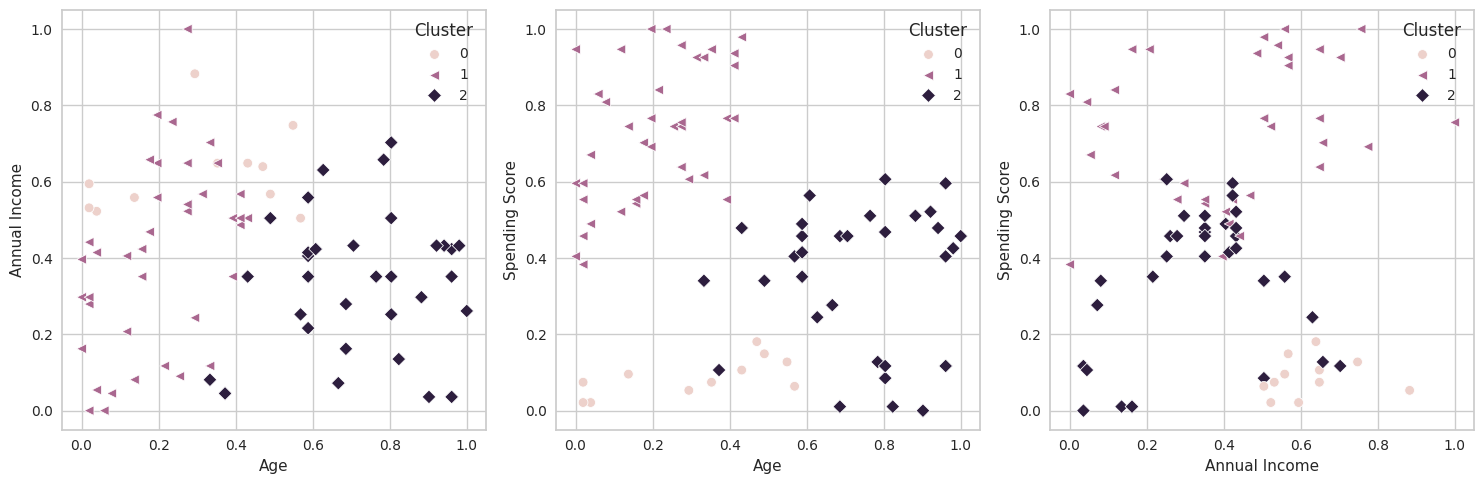

In [80]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

markers = ['o', '<', 'D']
sns.scatterplot(male_dataset, x='Age', y='Annual Income', hue='Cluster', ax=axs[0], markers=markers, style='Cluster')
sns.scatterplot(male_dataset, x='Age', y='Spending Score', hue='Cluster', ax=axs[1], markers=markers, style='Cluster')
sns.scatterplot(male_dataset, x='Annual Income', y='Spending Score', hue='Cluster', ax=axs[2], markers=markers, style='Cluster')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

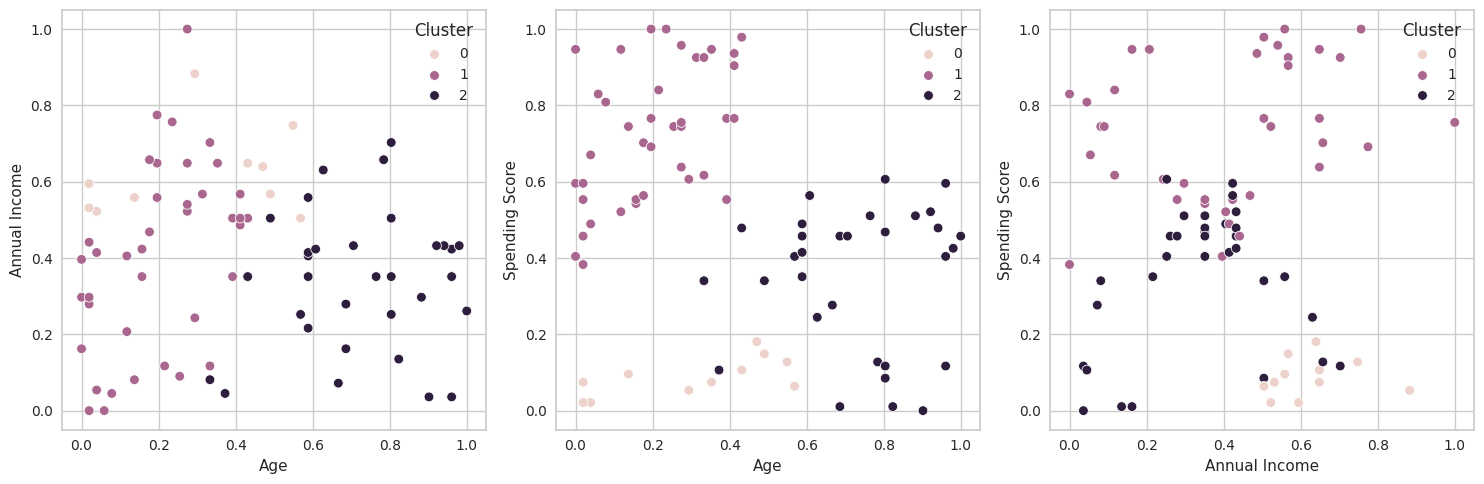

In [68]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(male_dataset, x='Age', y='Annual Income', hue='Cluster', ax=axs[0])
sns.scatterplot(male_dataset, x='Age', y='Spending Score', hue='Cluster', ax=axs[1])
sns.scatterplot(male_dataset, x='Annual Income', y='Spending Score', hue='Cluster', ax=axs[2])


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

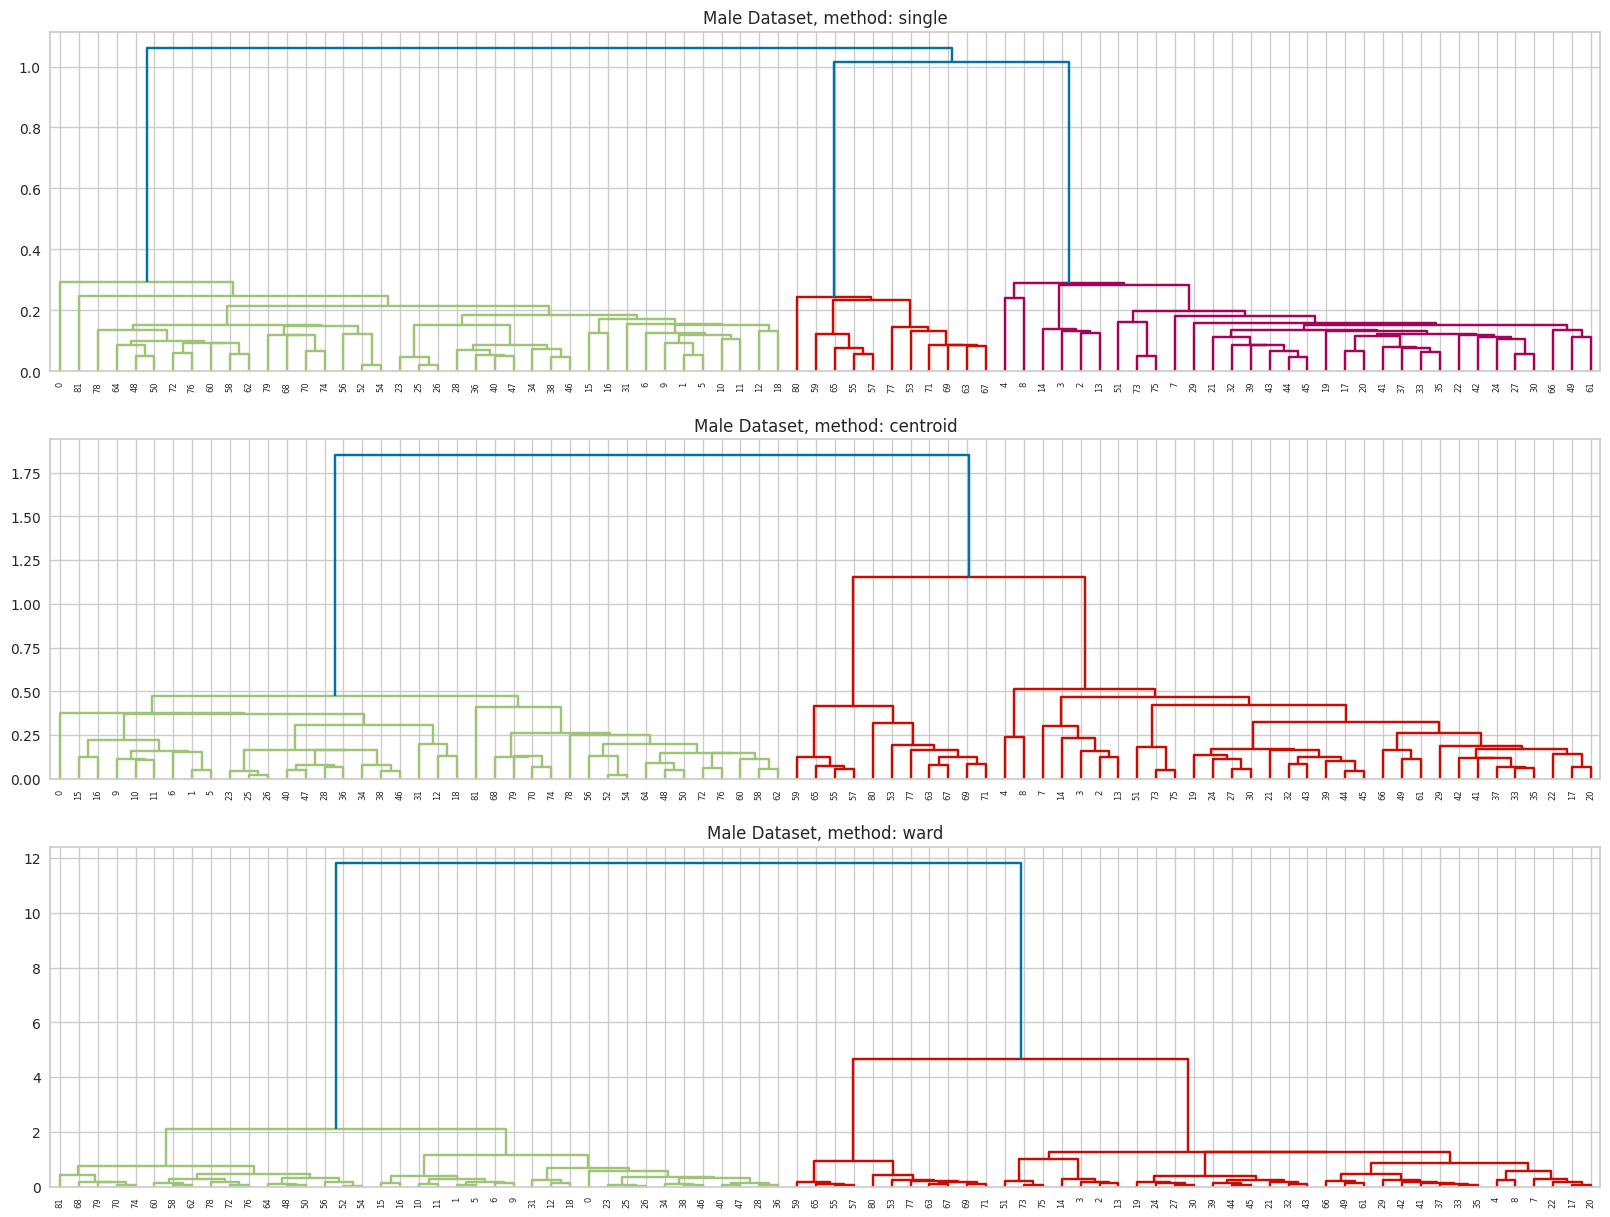

In [25]:
from scipy.cluster.hierarchy import linkage, dendrogram

methods = ['single', 'centroid', 'ward']

fig, axs = plt.subplots(len(methods), 1, figsize=(20,15))

for i, ax in enumerate(axs):
  ax.set_title('Male Dataset, method: {}'.format(methods[i]))
  mergings = linkage(male_dataset, method = methods[i])
  dendrogram(mergings, ax = ax)

##### Female Dataset

In [31]:

kmeans = KMeans(n_clusters=2, random_state=42) # Aplicar K-Means con K=8
kmeans.fit(female_dataset)

cluster_labels = kmeans.labels_ # Asis etiquetas de cluster a los datos

female_dataset['Cluster'] = cluster_labels # Agregar las etiquetas de cluster al conjunto de datos original

# Calcula la media de las variables numéricas y la moda de las variables categóricas
cluster_aggregated = female_dataset.groupby('Cluster').agg(lambda x: x.mode().iloc[0] if x.dtype == 'object' else x.mean())

print(cluster_aggregated)

         Genre  Age  Annual Income  Spending Score
Cluster                                           
0         0.00 0.54           0.37            0.36
1         0.00 0.19           0.41            0.68


/tmp/ipykernel_6869/612142176.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_dataset['Cluster'] = cluster_labels # Agregar las etiquetas de cluster al conjunto de datos original


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

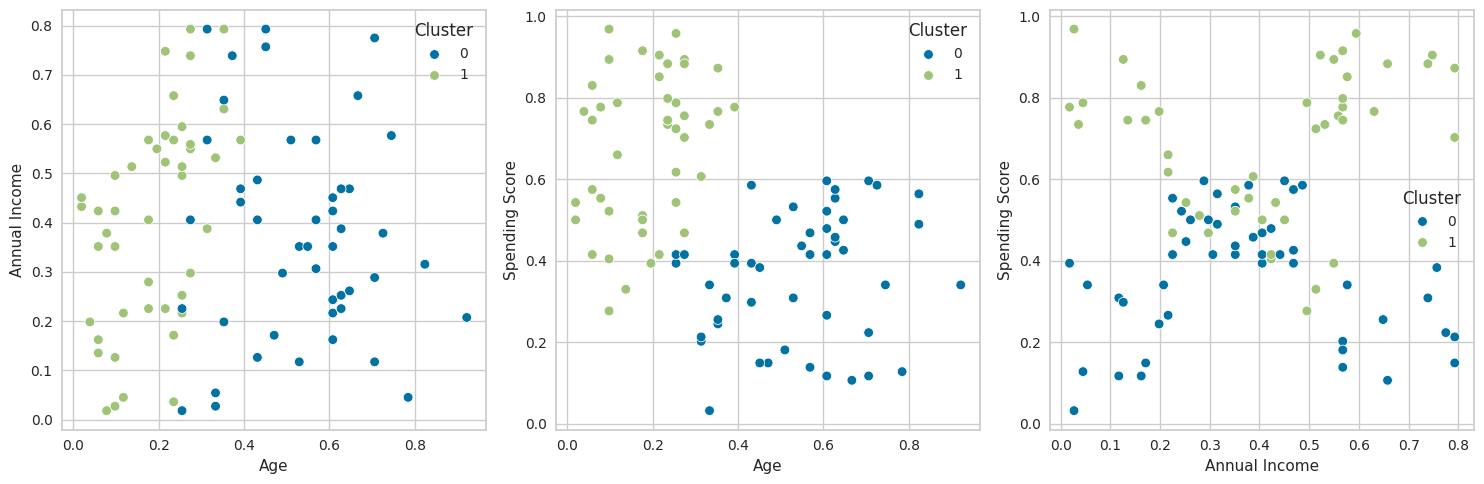

In [71]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(female_dataset, x='Age', y='Annual Income', hue='Cluster', ax=axs[0])
sns.scatterplot(female_dataset, x='Age', y='Spending Score', hue='Cluster', ax=axs[1])
sns.scatterplot(female_dataset, x='Annual Income', y='Spending Score', hue='Cluster', ax=axs[2])


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

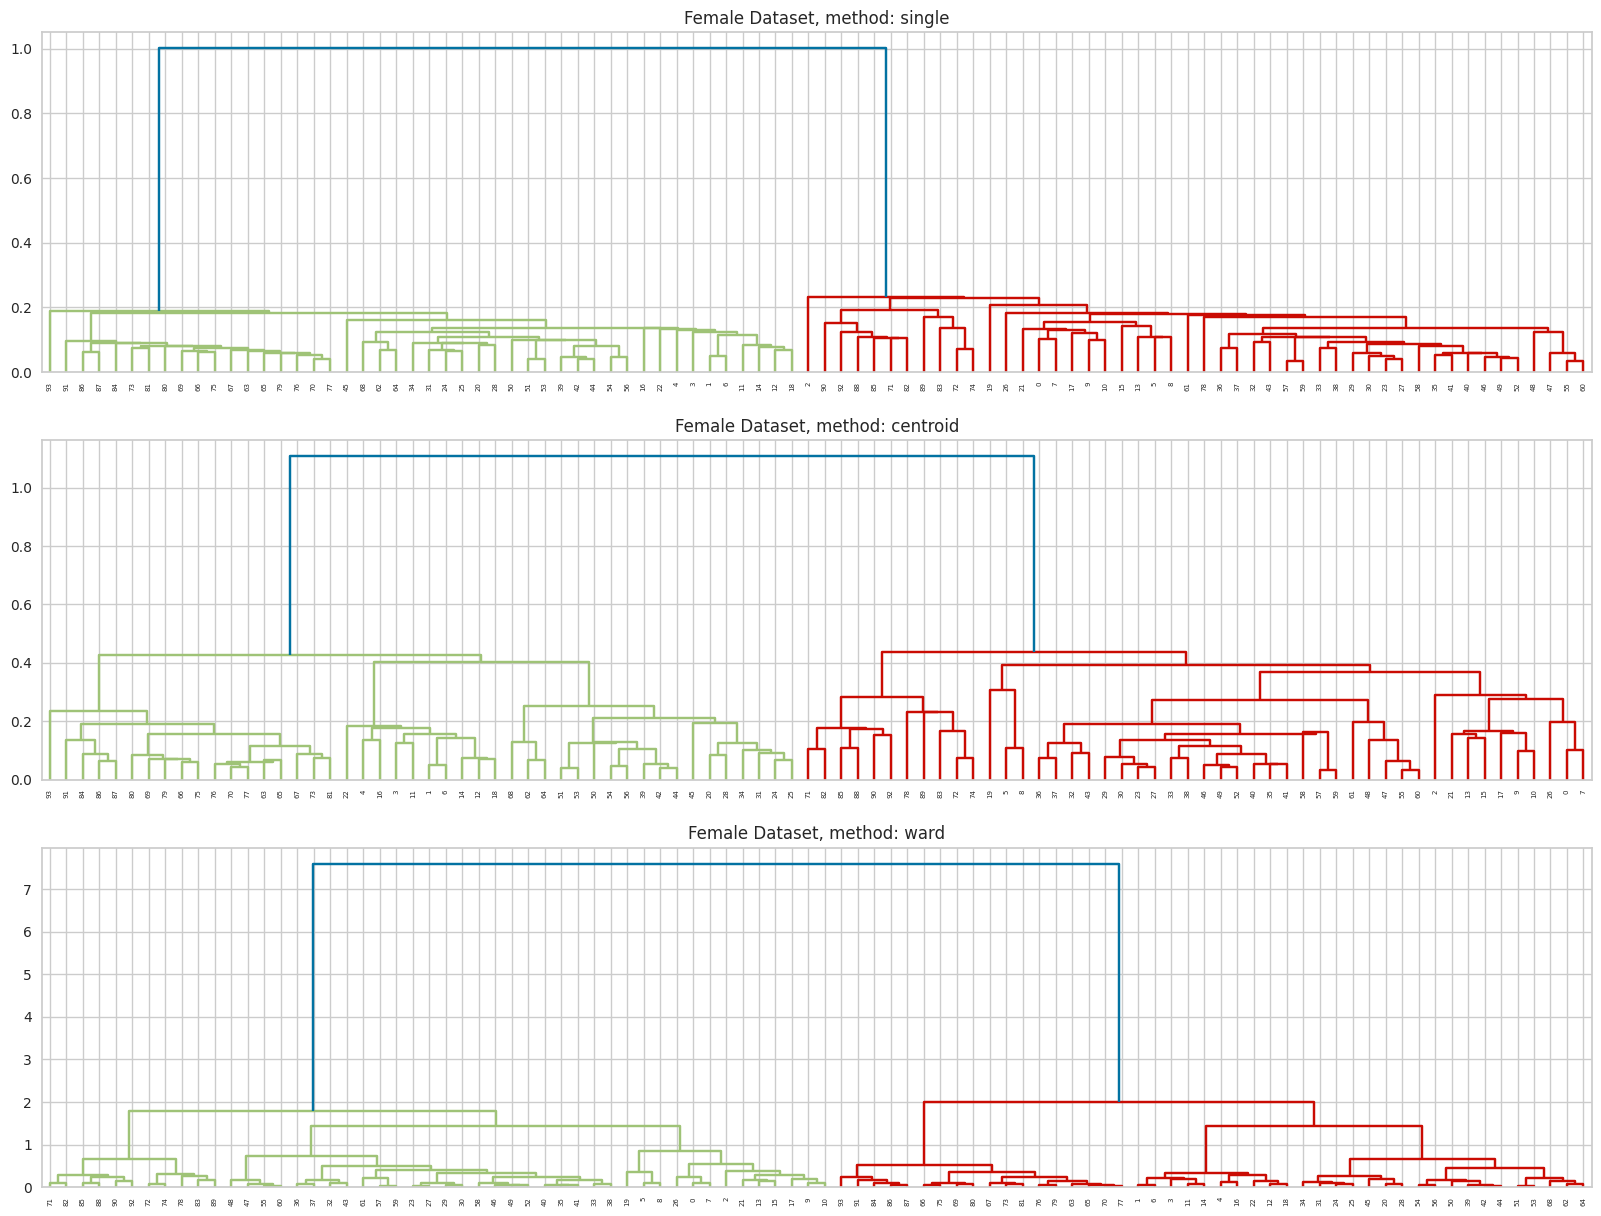

In [27]:
from scipy.cluster.hierarchy import linkage, dendrogram

methods = ['single', 'centroid', 'ward']

fig, axs = plt.subplots(len(methods), 1, figsize=(20,15))

for i, ax in enumerate(axs):
  ax.set_title('Female Dataset, method: {}'.format(methods[i]))
  mergings = linkage(female_dataset, method = methods[i])
  dendrogram(mergings, ax = ax)
  